# Labeled Convolutional CVAE

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)

# Settings

In [3]:
SAVE_NAME = 'cvae.conv.labeled'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 100
LR = 3e-04
BATCH_SIZE = 32


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: pallets_labels.json


In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Training

In [8]:
input_dim = 222
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92

In [9]:
model = M.cvae.LabeledConvCVAE(input_dim, latent_dim, classes_dim)
criterion = M.cvae.Loss()

train_losses, test_losses = M.cvae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, conditional_loss=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | model: pallets.models.cvae.LabeledConvCVAE
INFO | criterion: pallets.models.cvae.Loss
INFO | learn rate: 0.0003
INFO | epochs: 100


INFO | epoch 1 (  0%) loss: 2005726.250000
INFO | epoch 1 ( 35%) loss: 339873.233601
INFO | epoch 1 ( 70%) loss: 241921.033271
INFO | epoch 1 (100%) loss: 212578.157303
INFO | epoch 1 (test) loss: 135194.287170
INFO | epoch 2 (  0%) loss: 133063.625000
INFO | epoch 2 ( 35%) loss: 135468.649134
INFO | epoch 2 ( 70%) loss: 134701.380869
INFO | epoch 2 (100%) loss: 133864.933213
INFO | epoch 2 (test) loss: 129977.242432
INFO | epoch 3 (  0%) loss: 131311.171875
INFO | epoch 3 ( 35%) loss: 125220.036819
INFO | epoch 3 ( 70%) loss: 118753.395678
INFO | epoch 3 (100%) loss: 115943.919679
INFO | epoch 3 (test) loss: 107423.998474
INFO | epoch 4 (  0%) loss: 111806.335938
INFO | epoch 4 ( 35%) loss: 108740.759282
INFO | epoch 4 ( 70%) loss: 107635.042366
INFO | epoch 4 (100%) loss: 106917.455307
INFO | epoch 4 (test) loss: 104194.661621
INFO | epoch 5 (  0%) loss: 107273.109375
INFO | epoch 5 ( 35%) loss: 104704.202661
INFO | epoch 5 ( 70%) loss: 104120.509950
INFO | epoch 5 (100%) loss: 10312

# Results

## Random Inputs w/ Real Labels

In [10]:
import random

def rand_label():
    label_idx = int(random.random() * len(dataset._labels))
    features = dataset._labels[label_idx]
    enabled_names = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
    return features.to(device), enabled_names


In [11]:
# Generate new image

def rand_punk():
    z = torch.randn(1, latent_dim).to(device)
    # print(z.shape)
    features, names = rand_label()
    print(f"Features: {', '.join(names)}")

    with torch.no_grad():
        model.eval()
        generated_image = model.decoder(z, features.unsqueeze(0))
        # print(generated_image.shape)

    decoded_one_hot = generated_image[0][:222, :, :]
    decoded_one_hot = decoded_one_hot.view((222, 24, 24))
    # print(decoded_one_hot.shape)
    decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
    print(f"Shape: {decoded.shape}")
    return decoded


### 5 Randoms w/ Real Labels

Features: male, luxuriousBeard, frumpyHair, bigShades
Shape: torch.Size([4, 24, 24])
torch.Size([4, 24, 24])


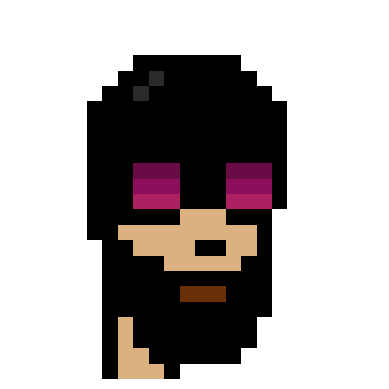

In [12]:
decoded = rand_punk()
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, pilotHelmet, cigarette
Shape: torch.Size([4, 24, 24])


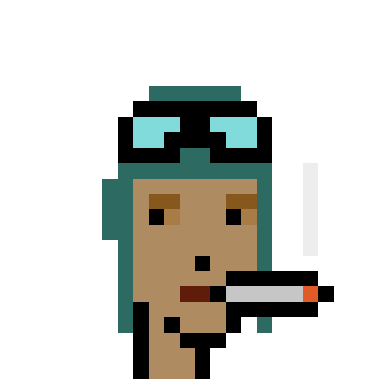

In [13]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, stringyHair
Shape: torch.Size([4, 24, 24])


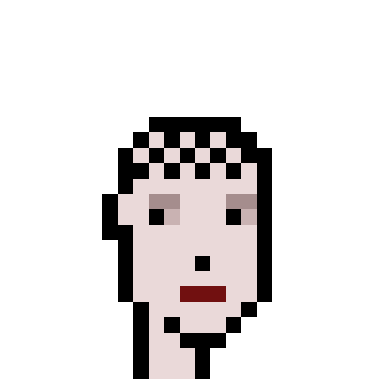

In [14]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, normalBeardBlack, eyeMask
Shape: torch.Size([4, 24, 24])


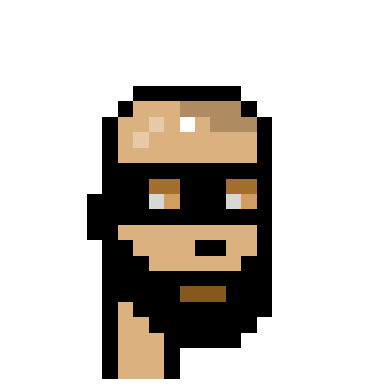

In [15]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, buckTeeth, messyHair, nerdGlasses


Shape: torch.Size([4, 24, 24])


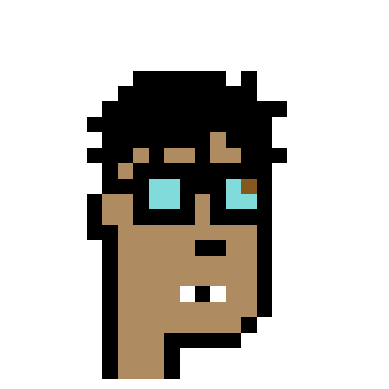

In [16]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


## Reconstruction

In [17]:
def reconstruct_punk(idx):
    punk = I.get_punk_tensor(idx)
    p = DS.rgba_to_one_hot(punk, dataset.mapper)
    p = p.unsqueeze(0)
    p = p.to(device)

    _, labels = dataset[idx]
    l = labels.unsqueeze(0)
    l = l.to(device)
    enabled_features = [k for k,v in zip(dataset._label_keys, labels) if v.item() == 1]

    model.eval()
    with torch.no_grad():
        reconstructed, mu, logvar = model.forward(p, l)

    recon_punk = reconstructed[0][:222, :, :].cpu()
    recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)

    return punk, recon_punk, enabled_features


def draw_two(img1, img2):
    page_size = 2
    view_x, view_y = 4*page_size, 2*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(1, 2, 1)
    plt.imshow(transforms.functional.to_pil_image(img1))
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(transforms.functional.to_pil_image(img2))
    plt.axis('off')
    plt.show()


### 5 Reconstructions

Features: female, rosyCheeks, darkHair, cigarette


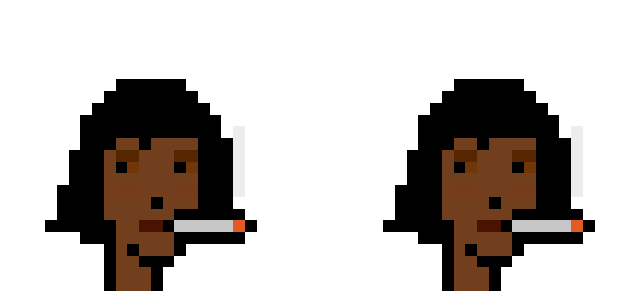

In [18]:
punk, recon_punk, features = reconstruct_punk(1000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: female, stringyHair, purpleLipstick, earring


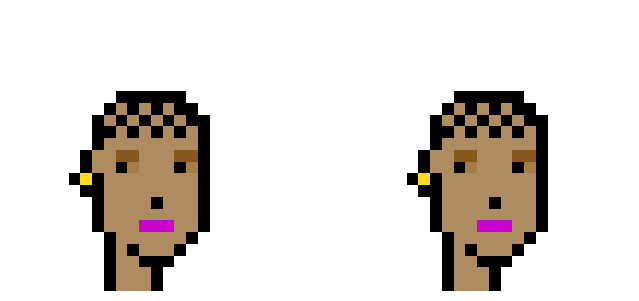

In [19]:
punk, recon_punk, features = reconstruct_punk(2001)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)


Features: female, wildWhiteHair, greenEyeShadow, hotLipstick


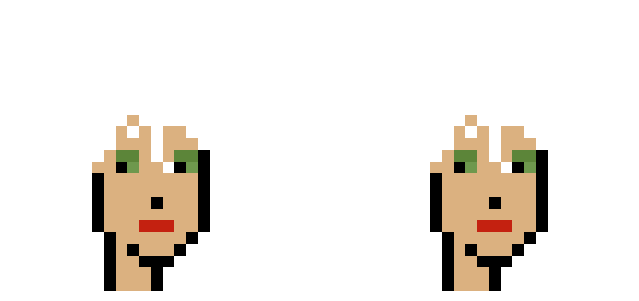

In [20]:
punk, recon_punk, features = reconstruct_punk(5000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, rosyCheeks, mustache, vr, cap, cigarette


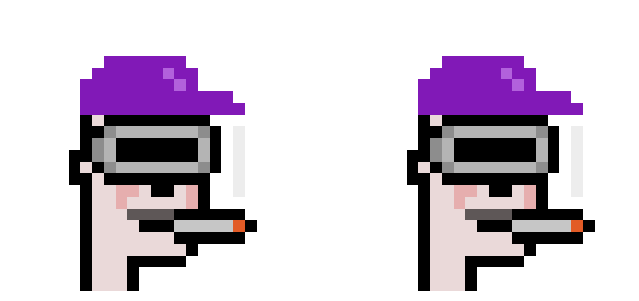

In [21]:
punk, recon_punk, features = reconstruct_punk(8000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, handlebars, bandana


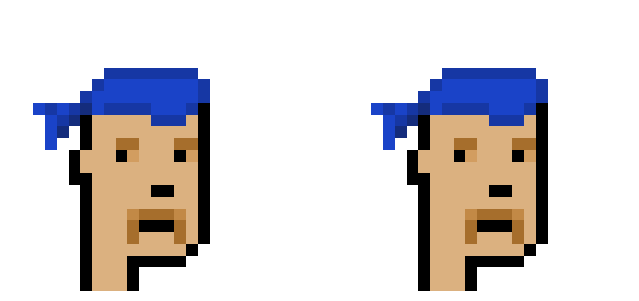

In [22]:
punk, recon_punk, features = reconstruct_punk(1337)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

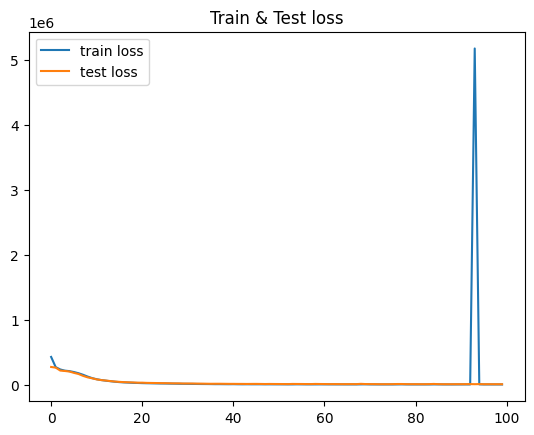

In [23]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [24]:
train_losses


[425156.3146054965,
 267729.86642564274,
 231887.83935893173,
 213834.91061336437,
 206240.89983654697,
 192189.33597905585,
 173946.75849124556,
 150144.55444509088,
 122305.58777288342,
 98320.38017370345,
 81170.9435533023,
 68698.74737159241,
 59022.19746301529,
 50819.763976617905,
 42693.27439847906,
 36651.54911901596,
 32359.010503241356,
 29133.100274268618,
 25648.687732020167,
 23782.33675216783,
 21315.563546687998,
 19561.63712045656,
 18337.803134350066,
 17082.110536832337,
 15676.963342544881,
 15188.184932194703,
 13772.001573927859,
 12877.6806640625,
 11409.90976839539,
 10563.760472940216,
 9633.537471257203,
 9008.873549873948,
 8180.066829167359,
 7463.052904927139,
 7052.160789976729,
 6318.84437571857,
 5340.495033210051,
 5359.741616972795,
 4748.680254564218,
 4246.967168713292,
 4906.268235659769,
 3636.610259793329,
 3089.1689903313386,
 3502.393220617416,
 3014.236694552374,
 3096.7494442987104,
 3023.4512034747618,
 2629.805183897627,
 2665.975208904726,
 

In [25]:
test_losses


[270388.5743408203,
 259954.48486328125,
 214847.9969482422,
 208389.3232421875,
 200367.4149169922,
 179334.4100341797,
 162466.49536132812,
 133166.53674316406,
 110549.38653564453,
 95741.35089111328,
 78761.55212402344,
 68026.17565917969,
 60996.156311035156,
 52732.08532714844,
 45530.54406738281,
 40474.853439331055,
 36194.074279785156,
 33640.6950378418,
 31641.249572753906,
 27663.828582763672,
 28068.390579223633,
 24894.384017944336,
 23707.58122253418,
 22681.81869506836,
 21285.30258178711,
 20348.808990478516,
 19083.667846679688,
 17475.273963928223,
 17595.408325195312,
 15282.889343261719,
 15392.192985534668,
 15185.566925048828,
 13635.368927001953,
 13069.493423461914,
 12060.987815856934,
 10933.153247833252,
 11233.328325271606,
 11377.771781921387,
 10581.217491149902,
 9776.831315994263,
 9749.686962127686,
 9080.00555229187,
 8966.444675445557,
 8295.91746711731,
 8938.720932006836,
 9193.868404388428,
 8454.735216140747,
 7363.685569763184,
 8365.852725982666